In [15]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

import json
import os
import time
import csv

import matplotlib.pyplot as plt
plt.rc('font', size=14)
import seaborn as sns
sns.set(style='whitegrid', color_codes=True, rc={'figure.figsize':(11,8)}, font_scale=2)

In [16]:
#os.chdir('/c/Users/matth/Documents/Coding/spotify/')

In [17]:
#!pwd

### EDA

In [18]:
df = pd.read_csv('./final/final_table.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19306 entries, 0 to 19305
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   endTime           19306 non-null  object 
 1   artistName        19306 non-null  object 
 2   trackName         19306 non-null  object 
 3   msPlayed          19306 non-null  int64  
 4   song_artist       19306 non-null  object 
 5   track_id          19306 non-null  object 
 6   danceability      19306 non-null  float64
 7   energy            19306 non-null  float64
 8   key               19306 non-null  float64
 9   loudness          19306 non-null  float64
 10  mode              19306 non-null  float64
 11  speechiness       19306 non-null  float64
 12  acousticness      19306 non-null  float64
 13  instrumentalness  19306 non-null  float64
 14  liveness          19306 non-null  float64
 15  valence           19306 non-null  float64
 16  tempo             19306 non-null  float6

In [19]:
df.drop(labels = ['song_artist','track_id'], axis=1, inplace=True)

In [20]:
for col in df.columns:
    print(col,':',len(df[col].unique()))

endTime : 9682
artistName : 1592
trackName : 2992
msPlayed : 6541
danceability : 657
energy : 778
key : 12
loudness : 2613
mode : 2
speechiness : 878
acousticness : 1697
instrumentalness : 1393
liveness : 895
valence : 922
tempo : 2855
duration_ms : 2948
time_signature : 4
genre : 263


**Categorical Variables**: key, mode (major or minor modality), time_signature, genre

**Continuous**: endTime, dancability, energy, loudness, speechiness, acousticness, intrumentalness, liveness, valence, tempo, duration

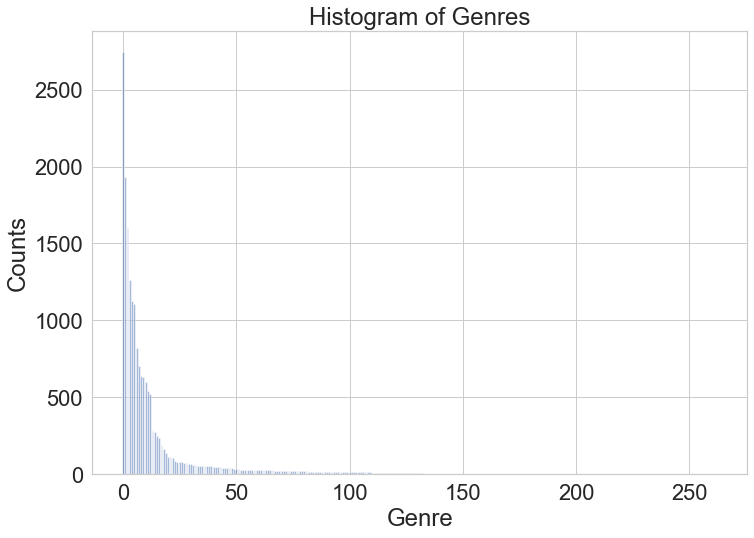

In [21]:
genre_counts = pd.DataFrame(df['genre'].value_counts())

objects = tuple(genre_counts.index)
y_pos = np.arange(len(objects))
counts = genre_counts['genre']

plt.bar(x = y_pos, height = counts, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.title('Histogram of Genres')
plt.xlabel('Genre')
plt.ylabel('Counts')
#plt.xticks(fontsize=5, rotation=90)
plt.tight_layout()
plt.savefig('./graphs/genre_histogram.png')
plt.show()

**Findings:**
Out of the 250+ genres in the dataset, only around 20 appear more than 250 times, with the vast majority appearing less than 100 times. 

In [22]:
# number of genres which appear at least 10 times
print(genre_counts[genre_counts['genre']>=10].shape[0])
gen_min10 = genre_counts[genre_counts['genre']>=10].index.tolist() # list of genres for removing outliers later

115


In [23]:
#gen_t25 = genre_counts.iloc[:25,:].index.tolist()

### Analysis
#### Pre-processing

In [24]:
# turning cat vars into one hot
dummy_col = ['key', 'mode', 'time_signature']
processing = pd.get_dummies(df, columns=dummy_col, drop_first=False) # including intercept since no standardizing
# https://stats.stackexchange.com/questions/224051/one-hot-vs-dummy-encoding-in-scikit-learn

In [25]:
# removing genres which appear less than 10 times
print('Before removing outliers:',processing.shape[0])
processing = processing[processing['genre'].isin(gen_min10)]
print('After removing outliers:',processing.shape[0])

Before removing outliers: 19306
After removing outliers: 18906


In [26]:
# label encoding genres
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
processing['genre_label'] = label_encoder.fit_transform(processing['genre'])

In [27]:
# dictionary to convert label-encoded genres back to actual genre names
revert_gen = {label: genre for (genre, label) in zip(processing['genre'],processing['genre_label'])}

In [28]:
#from sklearn.model_selection import train_test_split

X = processing.drop(labels = ['endTime','artistName','trackName','msPlayed','genre','genre_label'], axis=1, inplace=False)
y = processing['genre_label']

#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.8)

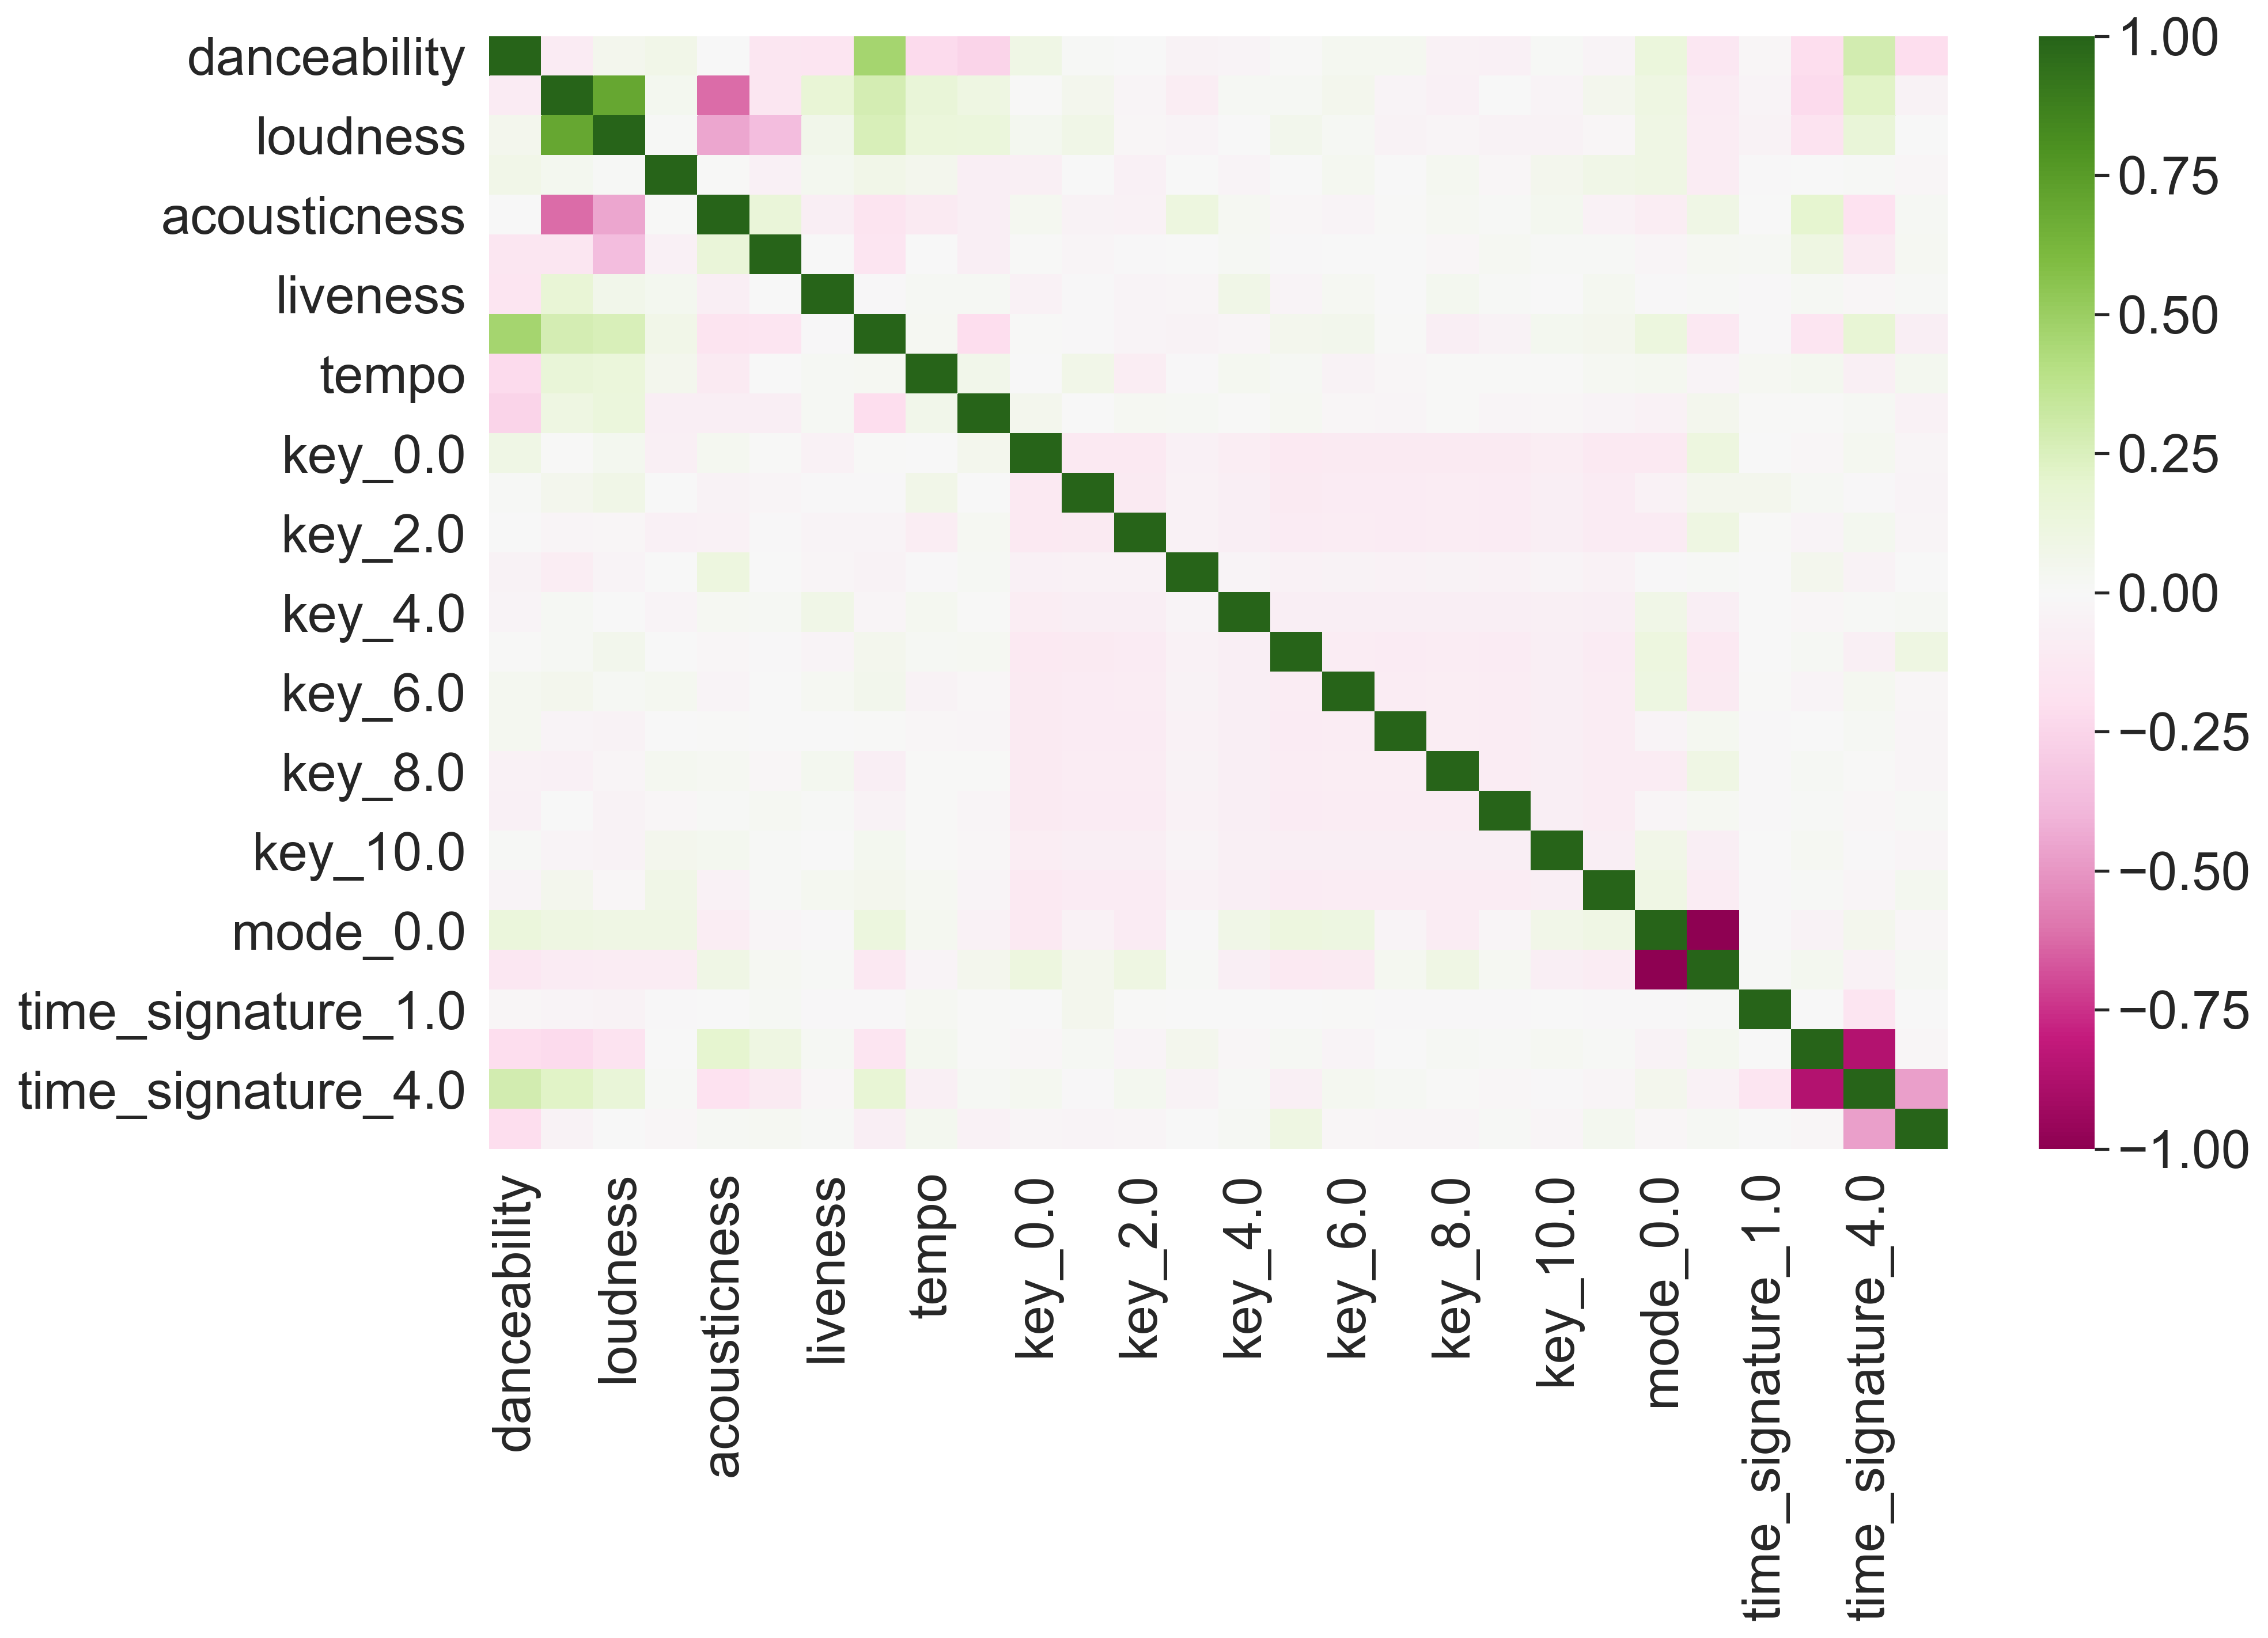

In [36]:
corr = X.corr()
fig = plt.figure(figsize=(14, 10),dpi=300,tight_layout=True)
sns.heatmap(corr, cmap="PiYG")
fig.savefig('./graphs/corr_heatmap.png')

In [30]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

In [31]:
skf.split(X, y)

<generator object _BaseKFold.split at 0x0000020A6F8AD148>

In [32]:
Xtr = []
ytr = []
Xte = []
yte = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    Xtr.append(X_train), Xte.append(X_test), ytr.append(y_train), yte.append(y_test)

In [33]:
X_train, X_test = Xtr[0], Xte[0]
y_train, y_test = ytr[0], yte[0]

#### Modeling Relationship between Audio Features and Genre

Testing multiple classification models without tuning.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

n_neighbors = 10

classifiers = {
    "MLR": LogisticRegression(multi_class='multinomial', solver='saga', random_state=42),
    "KNN": neighbors.KNeighborsClassifier(n_neighbors = n_neighbors, n_jobs = -1),
    "Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "GBoost": GradientBoostingClassifier(random_state=42)
}

y_test_preds = dict()

In [34]:
start_time = time.time()

for name, classifier in classifiers.items():
    model = classifier.fit(X_train, y_train)
    y_test_preds[name] = [model.predict(X_test),model.predict_proba(X_test),model]
    
print("Training took", time.time()-start_time) # 1493.0444922447205 s (25 min)

Training took 1054.5198285579681


#### Model Evaluation

In [35]:
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from pprint import pprint

for name in classifiers.keys():
    result = pd.DataFrame({'True':y_test,'Predict':y_test_preds[name][0]})
    result['Correct'] = np.where(result.iloc[:,0] == result.iloc[:,1],1,0)
    acc = (result['Correct'] == 1).sum()/result.shape[0]
       
    t5_acc = top_k_accuracy_score(y_test,y_test_preds[name][1], k=5)
    
    logloss = log_loss(y_test,y_test_preds[name][1])
    f1 = f1_score(y_test, y_test_preds[name][0], average='macro')
    
    if name=='RF':
        pprint(y_test_preds[name][2].get_params())

    print(name)
    print('Accuracy:', acc, '\t Top 5 Accuracy:', t5_acc)
    print('LogLoss:',logloss, '\t F1:',f1,'\n')

MLR
Accuracy: 0.14516129032258066 	 Top 5 Accuracy: 0.45716552088841883
LogLoss: 3.4572850411087455 	 F1: 0.002204531537048377 

KNN
Accuracy: 0.8191433104177683 	 Top 5 Accuracy: 0.9272871496562666
LogLoss: 2.650250051995408 	 F1: 0.6992834147595346 

Tree
Accuracy: 0.9264939185616076 	 Top 5 Accuracy: 0.9275515600211528
LogLoss: 2.5388101104668435 	 F1: 0.8612057683959463 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
RF
Accuracy: 0.9328397673188789 	 Top 5 Accuracy: 0.9616604970914859
LogLoss: 0.6472597433756473 	 F1: 0.894440599427882 

GBoost
Accuracy: 0.9013749338974087 	 Top 5 Accuracy: 0.9542570068746695
LogLoss: 1.127179

#### Feature Importances

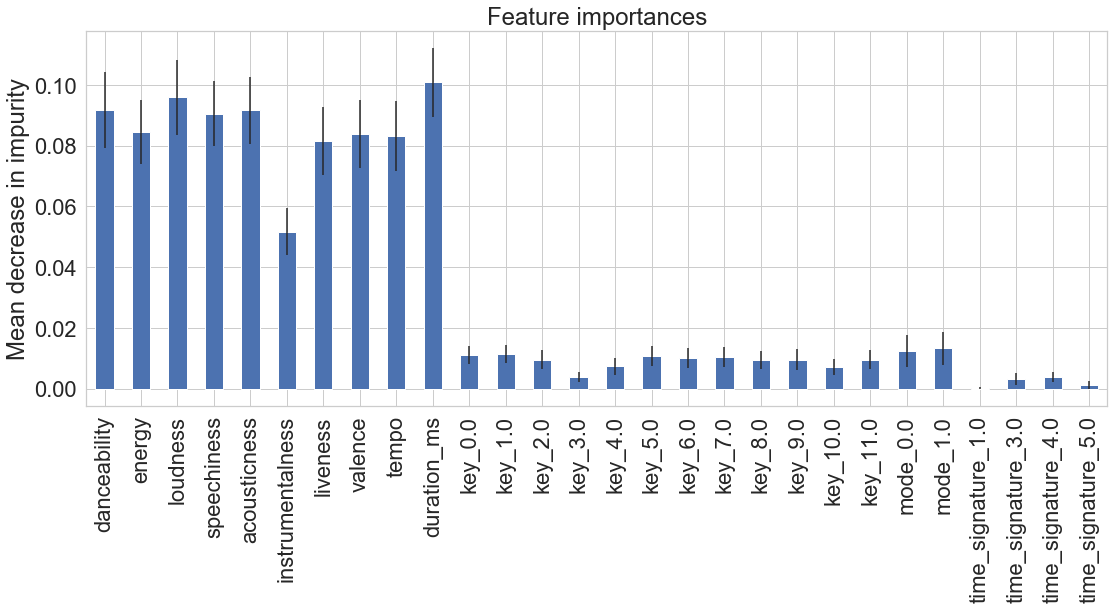

In [36]:
# RF
RF = y_test_preds['RF'][2]

feature_names = X.columns
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize =(16, 9))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [37]:
# Gradient Boost
'''
GB = y_test_preds['GBoost'][2]

plt.bar(range(len(GB.feature_importances_)), GB.feature_importances_)
plt.show()
'''

'''
feature_names = X.columns
importances = GB.feature_importances_
std = np.std([tree.feature_importances_ for tree in GB.estimators_], axis=0)
boost_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize =(16, 9))
boost_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
'''

'\nfeature_names = X.columns\nimportances = GB.feature_importances_\nstd = np.std([tree.feature_importances_ for tree in GB.estimators_], axis=0)\nboost_importances = pd.Series(importances, index=feature_names)\n\nfig, ax = plt.subplots(figsize =(16, 9))\nboost_importances.plot.bar(yerr=std, ax=ax)\nax.set_title("Feature importances")\nax.set_ylabel("Mean decrease in impurity")\nfig.tight_layout()\n'

### Model Tuning

#### RF and Gradient Boosting

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint
start_time = time.time()
# rf
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators':randint(2,200),
    'min_samples_split': randint(1,5),
    'max_features': randint(3,15)
}
rf_clf = RandomizedSearchCV(rf, rf_params, n_iter=100, cv=5, random_state=42)
model = rf_clf.fit(X_train,y_train)

preds, probs = model.predict(X_test), model.predict_proba(X_test)

result = pd.DataFrame({'True':y_test,'Predict':preds})
result['Correct'] = np.where(result.iloc[:,0] == result.iloc[:,1],1,0)
acc = (result['Correct'] == 1).sum()/result.shape[0]

t5_acc = top_k_accuracy_score(y_test,probs, k=5)

logloss = log_loss(y_test,probs)
f1 = f1_score(y_test, preds, average='macro')

print('Random Forest')
print('Accuracy:', acc, '\t Top 5 Accuracy:', t5_acc)
print('LogLoss:',logloss, '\t F1:',f1,'\n')

pprint(model.best_estimator_.get_params())
print("Train+tune took", time.time()-start_time) # 2608.0745537281036 (~46 m)

Random Forest
Accuracy: 0.9333685880486515 	 Top 5 Accuracy: 0.9640401903754627
LogLoss: 0.5026837642236199 	 F1: 0.8983295438975272 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 188,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
Train+tune took 2784.955373764038


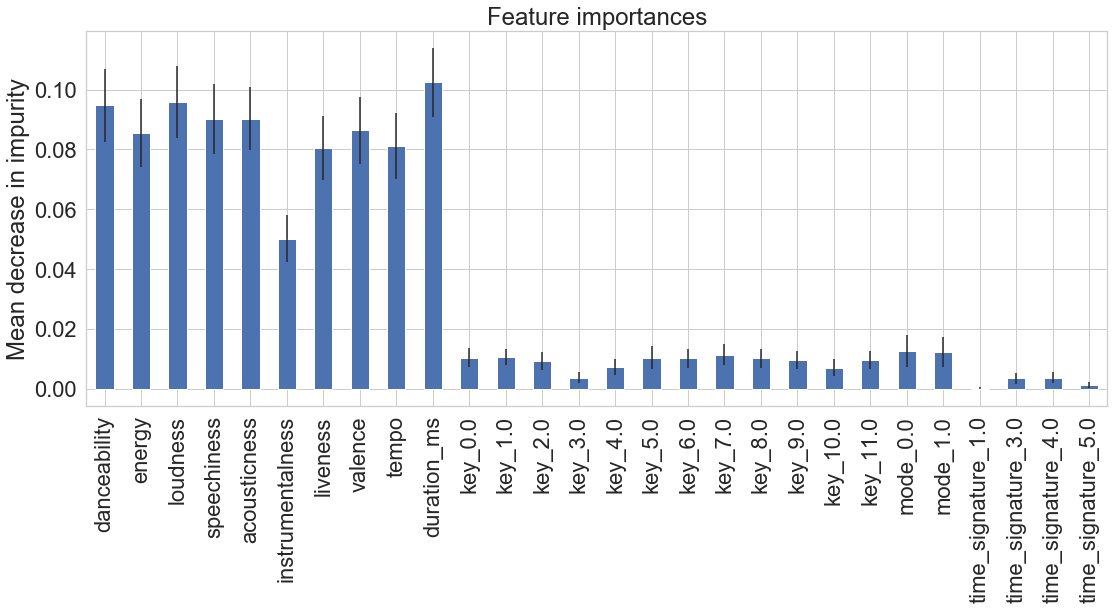

In [41]:
# RF
RF = model.best_estimator_

feature_names = X.columns
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize =(16, 9))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('./graphs/RF_featimp.png')
plt.show()

In [42]:
# gb
gb = GradientBoostingClassifier(random_state=42)
gb_params = {
    'n_estimators':randint(90,150),
    'subsample':uniform(0.1,0.9),
    'min_samples_split':uniform(0.01, 0.199)
}

gb_clf = RandomizedSearchCV(gb, gb_params, n_iter=100, cv=5, random_state=42)
model = gb_clf.fit(X_train,y_train)

preds, probs = model.predict(X_test), model.predict_proba(X_test)

result = pd.DataFrame({'True':y_test,'Predict':preds})
result['Correct'] = np.where(result.iloc[:,0] == result.iloc[:,1],1,0)
acc = (result['Correct'] == 1).sum()/result.shape[0]

t5_acc = top_k_accuracy_score(y_test,probs, k=5)

logloss = log_loss(y_test,probs)
f1 = f1_score(y_test, preds, average='macro')

print('Gradient Boosting')
print('Accuracy:', acc, '\t Top 5 Accuracy:', t5_acc)
print('LogLoss:',logloss, '\t F1:',f1,'\n')
pprint(model.best_estimator_.get_params())

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-40434a5fdb09>", line 10, in <module>
    model = gb_clf.fit(X_train,y_train)
  File "C:\Users\matth\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\matth\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1768, in _run_search
    self.param_distributions, self.n_iter, random_state=self.random_state
  File "C:\Users\matth\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 851, in evaluate_candidates
    enumerate(candidate_params), enumerate(cv.split(X, y, groups))
  File "C:\Users\matth\anaconda3\lib\site-packages\joblib\parallel.py", line 1007, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\lib

KeyboardInterrupt: 

### Searching for New Genres via Clustering

#### K-means

**Elbow Method**

In [43]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,18906.0,0.637600,0.137663,0.067000,0.5520,0.6490,0.732000,0.972
energy,18906.0,0.700179,0.176581,0.005790,0.5950,0.7250,0.842000,0.993
loudness,18906.0,-5.696439,2.593521,-35.072000,-6.6540,-5.4850,-4.082000,0.034
speechiness,18906.0,0.073621,0.061449,0.023300,0.0377,0.0523,0.085700,0.712
acousticness,18906.0,0.195492,0.231738,0.000007,0.0160,0.0954,0.304750,0.996
instrumentalness,18906.0,0.024918,0.127917,0.000000,0.0000,0.0000,0.000123,0.977
liveness,18906.0,0.177780,0.123653,0.011400,0.0957,0.1280,0.241000,0.991
valence,18906.0,0.579263,0.214458,0.026200,0.4200,0.5920,0.755000,0.977
tempo,18906.0,123.322605,27.380580,48.973000,101.1400,120.0440,140.015000,207.970
duration_ms,18906.0,204607.227441,41799.470959,38987.000000,179217.5000,201524.0000,223123.000000,700639.000


In [45]:
from sklearn.cluster import KMeans

wcss = []
start = 1
end = 200

start_time = time.time()

for i in range(start, end):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=42)
    clustering.fit(X)
    wcss.append(clustering.inertia_)
    
ks = list(range(start,end))
sns.lineplot(x = ks, y = wcss)

print("Generating elbow took", time.time()-start_time) # 610.1405174732208 s (12 min)

KeyboardInterrupt: 

In [46]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
scaled = ss.fit_transform(X)

wcss = []
start = 1
end = 200

start_time = time.time()

for i in range(start, end):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=42)
    clustering.fit(X)
    wcss.append(clustering.inertia_)
    
ks = list(range(start,end))
sns.lineplot(x = ks, y = wcss)

print("Generating elbow took", time.time()-start_time) # 610.5756132602692 s (12 min)

KeyboardInterrupt: 

In [47]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(X)
visualizer.show()

KeyboardInterrupt: 

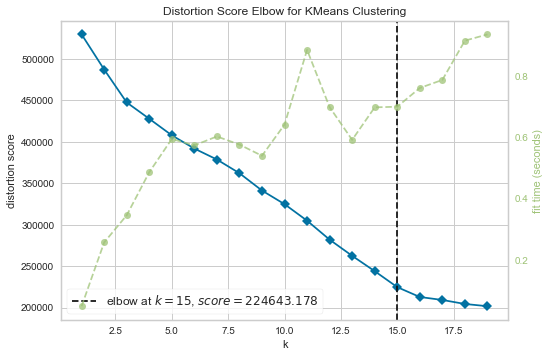

In [51]:
model = KMeans(random_state=42)
ax = plt.axes()
visualizer = KElbowVisualizer(model, ax=ax, k=(1,20))

visualizer.fit(scaled)
visualizer.show()
ax.figure.savefig('./graphs/kmeans_elbow.png')
visualizer.show()

**Model Refit and Assigning New Clusters**

In [34]:
final_model = KMeans(n_clusters=15, init='k-means++', random_state=42)
final_model.fit(scaled)

KMeans(n_clusters=15, random_state=42)

In [35]:
final_df = df[df['genre'].isin(gen_min10)]
final_df['clusters'] = final_model.predict(scaled)

In [36]:
final_df.shape

(18906, 19)

In [37]:
for x in range(0,15):
    temp = final_df[final_df['clusters']==x]
    print('Cluster',x)
    print(pd.DataFrame(temp['genre'].value_counts()).iloc[:5,:])

Cluster 0
            genre
korean        167
indie         127
k-pop         108
electronic     78
pop            77
Cluster 1
         genre
k-pop      188
j-pop      188
indie      132
hip-hop    113
rnb         93
Cluster 2
           genre
indie        323
pop          198
j-pop        198
k-pop         96
indie pop     86
Cluster 3
           genre
indie        226
indie pop    209
k-pop        176
korean       176
lo-fi        168
Cluster 4
         genre
indie      319
k-pop      189
j-pop      162
hip-hop    121
korean     115
Cluster 5
         genre
indie      147
rock       140
k-pop      136
korean     120
hip-hop    115
Cluster 6
            genre
indie         556
korean        185
k-pop         145
japanese      134
indie rock    111
Cluster 7
          genre
indie       382
korean      297
k-pop       251
j-pop       172
japanese    105
Cluster 8
            genre
soundtrack     12
electronic      2
k-pop           2
soul            1
chillout        1
Cluster 9
      

In [38]:
cluster_toGen = dict()

for x in range(0,15):
    temp = final_df[final_df['clusters']==x]
    counts = pd.DataFrame(temp['genre'].value_counts())
    genre = counts.index[0]
    if(genre in list(cluster_toGen.values())):
        y=1
        while(genre in list(cluster_toGen.values())):
            genre = counts.index[y]
            y+=1
    cluster_toGen[x] = genre

In [39]:
cluster_toGen

{0: 'korean',
 1: 'k-pop',
 2: 'indie',
 3: 'indie pop',
 4: 'j-pop',
 5: 'rock',
 6: 'japanese',
 7: 'lo-fi',
 8: 'soundtrack',
 9: 'electronic',
 10: 'hip-hop',
 11: 'pop',
 12: 'rnb',
 13: 'electro',
 14: 'funk'}

#### Mapping New 'Genres' Back to Original Data

In [40]:
final_df['new_gen'] = final_df['clusters'].replace(cluster_toGen)

In [41]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18906 entries, 1 to 19305
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   endTime           18906 non-null  object 
 1   artistName        18906 non-null  object 
 2   trackName         18906 non-null  object 
 3   msPlayed          18906 non-null  int64  
 4   danceability      18906 non-null  float64
 5   energy            18906 non-null  float64
 6   key               18906 non-null  float64
 7   loudness          18906 non-null  float64
 8   mode              18906 non-null  float64
 9   speechiness       18906 non-null  float64
 10  acousticness      18906 non-null  float64
 11  instrumentalness  18906 non-null  float64
 12  liveness          18906 non-null  float64
 13  valence           18906 non-null  float64
 14  tempo             18906 non-null  float64
 15  duration_ms       18906 non-null  float64
 16  time_signature    18906 non-null  float6

In [42]:
final_df.to_csv(path_or_buf = './final/final_newGen.csv', index = False)

In [13]:
df = pd.read_csv('./final/final_newGen.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18906 entries, 0 to 18905
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   endTime           18906 non-null  object 
 1   artistName        18906 non-null  object 
 2   trackName         18906 non-null  object 
 3   msPlayed          18906 non-null  int64  
 4   danceability      18906 non-null  float64
 5   energy            18906 non-null  float64
 6   key               18906 non-null  float64
 7   loudness          18906 non-null  float64
 8   mode              18906 non-null  float64
 9   speechiness       18906 non-null  float64
 10  acousticness      18906 non-null  float64
 11  instrumentalness  18906 non-null  float64
 12  liveness          18906 non-null  float64
 13  valence           18906 non-null  float64
 14  tempo             18906 non-null  float64
 15  duration_ms       18906 non-null  float64
 16  time_signature    18906 non-null  float6

In [14]:
len(df['genre'].unique())

115